In [2]:
from xopt import Xopt
from xopt.utils import read_xopt_csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from pmd_beamphysics import ParticleGroup, particle_paths, single_particle
from pmd_beamphysics.plot import density_plot
from distgen import Generator
import yaml
import pandas as pd
from glob import glob

In [3]:
#OUTPUT_PATH = "cav_run2_20250714/"
OUTPUT_PATH = "temp/"

In [4]:
# find all popolation files and sort by generation
pop_files = sorted(glob(OUTPUT_PATH + "cnsga_population*"))
len(pop_files)

28

In [5]:
# Read all population files and combine into one dataframe
all_populations = []
for i, file in enumerate(pop_files):
    df = read_xopt_csv(file)
    df['generation'] = i
    all_populations.append(df)

# Combine all generations
pop_df = pd.concat(all_populations, ignore_index=True)
print(f"Total evaluations: {len(pop_df)}")
print(f"Number of generations: {pop_df['generation'].nunique()}")
pop_df.head()

Total evaluations: 896
Number of generations: 28


,phase,phase3,voltage,voltage3,gamma_error,energy_spread,sigma_energy,mean_gamma,n_alive_ratio,ID,xopt_runtime,xopt_error,generation
0,0.018272,0.547448,861933.179015,459992.478184,0.000062,0.001615,20801.967216,25.199341,1.0,d6d07ae5df0976ec5da6935925554a5a,2859.548656,False,0
1,0.016279,0.540061,852060.513489,370210.587568,0.000016,0.003404,44359.652450,25.501727,1.0,d55c583d7df1d29f3ac0c73b35ac6050,2878.816883,False,0
2,0.017560,0.548732,830899.474149,413154.993940,0.001039,0.000790,9926.157166,24.581437,1.0,c2b3a3ef996dff5fdaae5909e26f3e90,2889.682132,False,0
3,0.010882,0.538676,855620.125775,369827.934624,0.000128,0.001346,17672.658587,25.687460,1.0,03945f6d01cdb7b9d64c9444f9f83401,2895.767990,False,0
4,0.013732,0.535845,878680.949556,444071.754634,0.000296,0.000997,13164.505172,25.836969,1.0,abb01ebbfd8db0b56493c9a266600886,2902.955584,False,0


In [6]:
# Define variables and objectives
variables = ['phase', 'phase3', 'voltage', 'voltage3']
objectives = ['gamma_error', 'energy_spread']

print("Variables:", variables)
print("Objectives:", objectives)
print("\nData ranges:")
for var in variables:
    print(f"{var}: [{pop_df[var].min():.6f}, {pop_df[var].max():.6f}]")
for obj in objectives:
    print(f"{obj}: [{pop_df[obj].min():.2e}, {pop_df[obj].max():.2e}]")

Variables: ['phase', 'phase3', 'voltage', 'voltage3']
Objectives: ['gamma_error', 'energy_spread']

Data ranges:
phase: [0.010084, 0.019773]
phase3: [0.530005, 0.549255]
voltage: [781557.283526, 878680.949556]
voltage3: [356903.025512, 459992.478184]
gamma_error: [7.50e-12, 8.25e-03]
energy_spread: [1.31e-04, 7.48e-03]


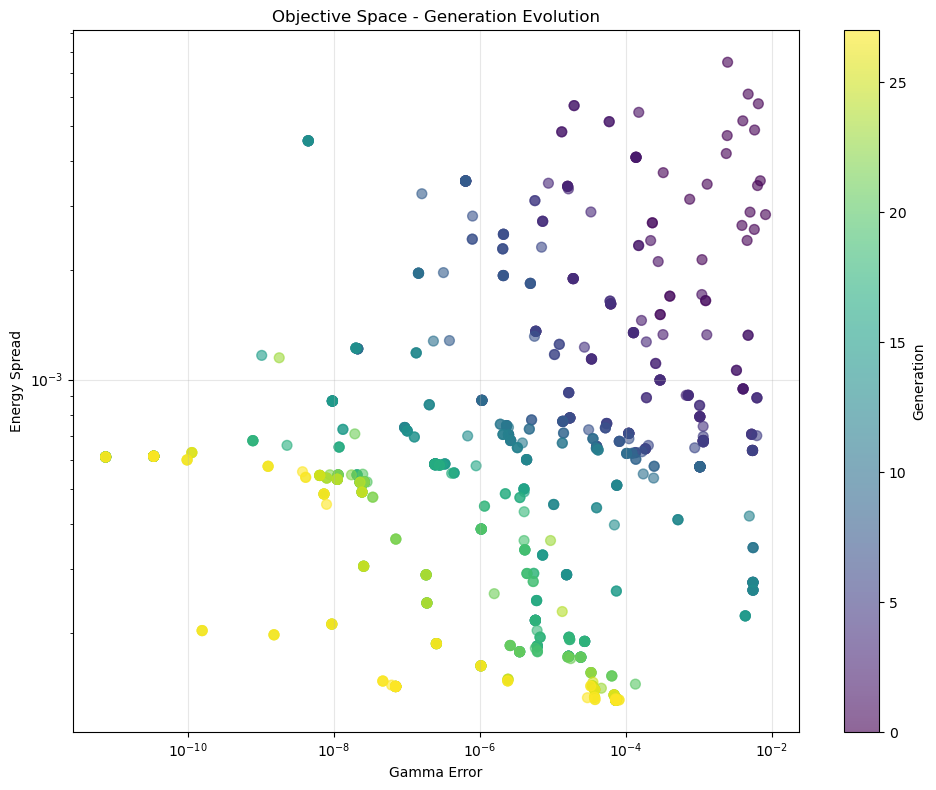

In [7]:
# 2. Objective space plot (Pareto front)
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot with color based on generation
scatter = ax.scatter(pop_df['gamma_error'], pop_df['energy_spread'], 
                    c=pop_df['generation'], cmap='viridis', alpha=0.6, s=50)

ax.set_xlabel('Gamma Error')
ax.set_ylabel('Energy Spread')
ax.set_title('Objective Space - Generation Evolution')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Generation')

plt.tight_layout()
plt.show()

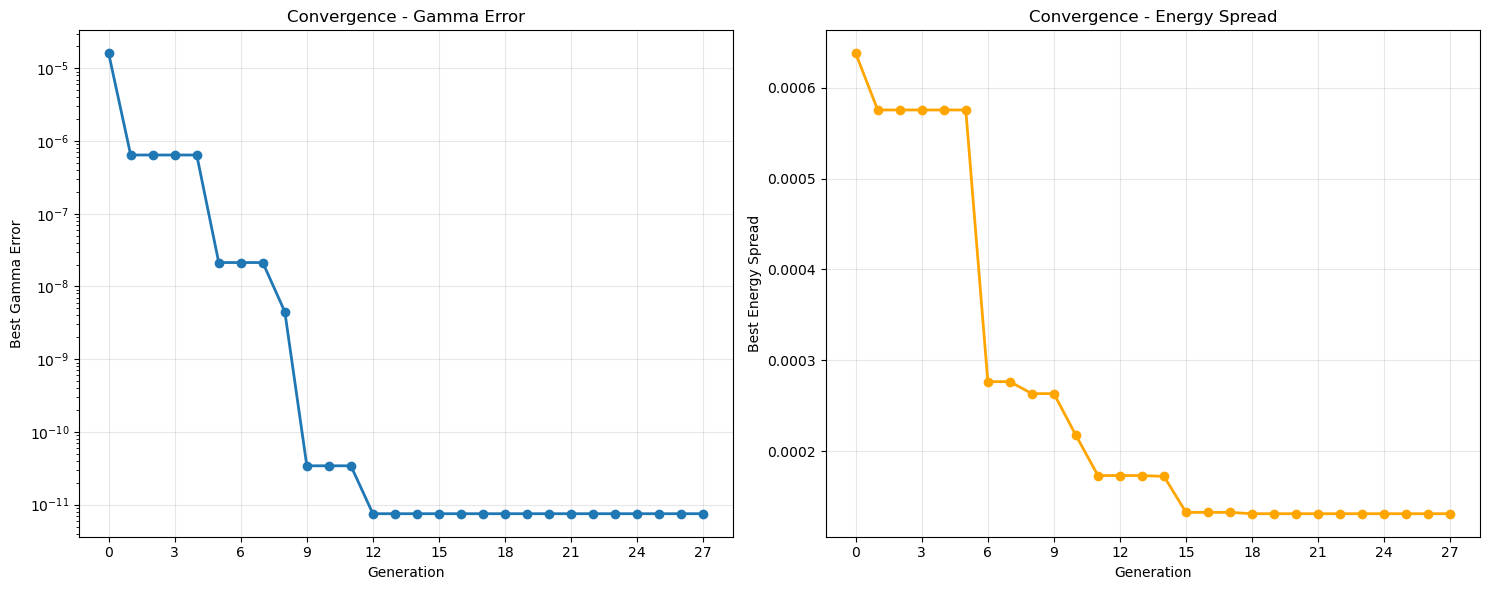

In [8]:
# 3. Convergence analysis - Best objectives over generations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate best values per generation
best_per_gen = pop_df.groupby('generation').agg({
    'gamma_error': 'min',
    'energy_spread': 'min'
}).reset_index()

# Plot convergence
axes[0].plot(best_per_gen['generation'], best_per_gen['gamma_error'], 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Best Gamma Error')
axes[0].set_title('Convergence - Gamma Error')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
# Force integer x-ticks
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axes[1].plot(best_per_gen['generation'], best_per_gen['energy_spread'], 'o-', linewidth=2, markersize=6, color='orange')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Best Energy Spread')
axes[1].set_title('Convergence - Energy Spread')
axes[1].grid(True, alpha=0.3)
# Force integer x-ticks
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

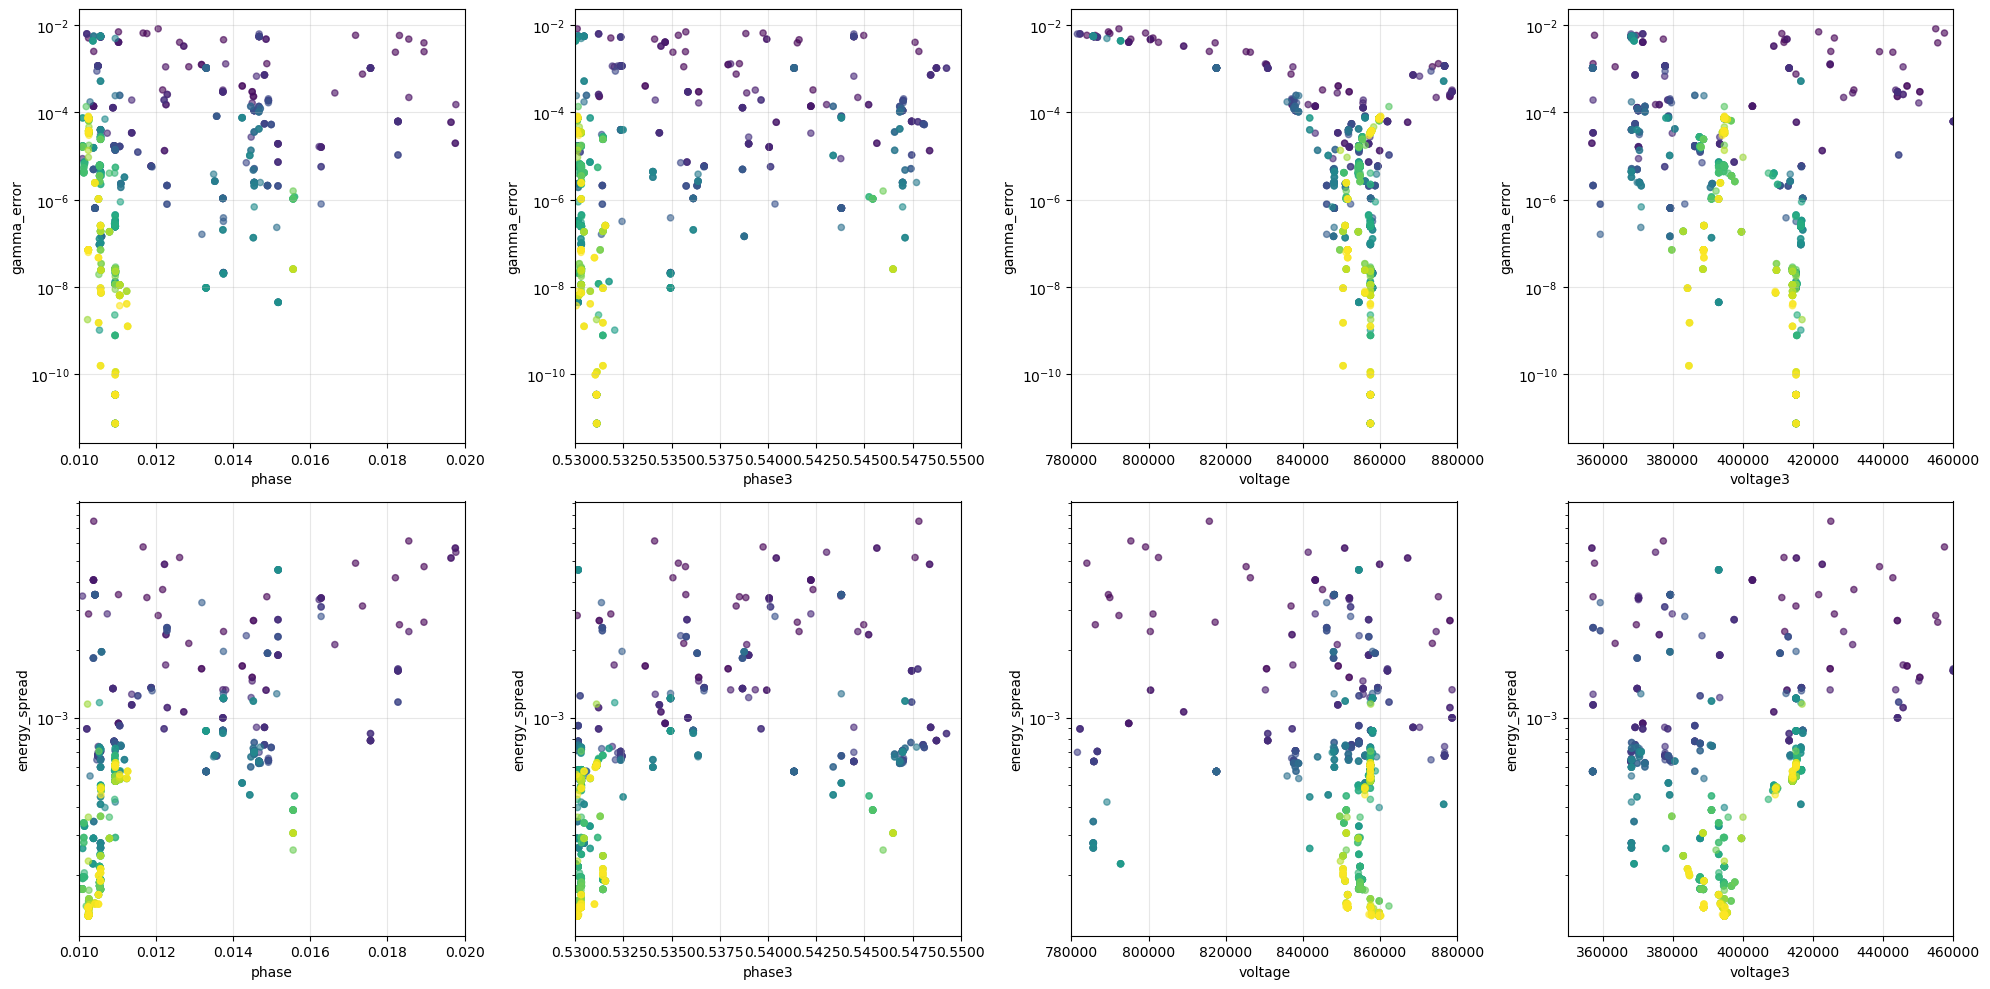

In [9]:
# 5. Variable vs Objective relationships
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, var in enumerate(variables):
    for j, obj in enumerate(objectives):
        ax = axes[j, i]
        ax.scatter(pop_df[var], pop_df[obj], alpha=0.6, s=20, c=pop_df['generation'], cmap='viridis')
        ax.set_xlabel(var)
        ax.set_ylabel(obj)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        if var == 'phase':
            ax.set_xlim(0.01, 0.02)
        elif var == 'phase3':
            ax.set_xlim(0.53, 0.55)
        elif var == 'voltage':
            ax.set_xlim(780e3, 880e3)
        elif var == 'voltage3':
            ax.set_xlim(350e3, 460e3)

plt.tight_layout()
plt.show()

In [10]:
# 6. Find and analyze the best solutions
print("=== BEST SOLUTIONS ANALYSIS ===")

# Remove duplicates based on ID (keep first occurrence)
pop_df_unique = pop_df.drop_duplicates(subset=['ID'], keep='first')
print(f"Original solutions: {len(pop_df)}")
print(f"Unique solutions (after removing duplicates): {len(pop_df_unique)}")

# Find Pareto optimal solutions (non-dominated)
def is_dominated(row, df):
    """Check if a solution is dominated by any other solution"""
    for _, other_row in df.iterrows():
        if (other_row['gamma_error'] <= row['gamma_error'] and 
            other_row['energy_spread'] <= row['energy_spread'] and
            (other_row['gamma_error'] < row['gamma_error'] or 
             other_row['energy_spread'] < row['energy_spread'])):
            return True
    return False

# Find non-dominated solutions from unique dataset
pareto_front = []
for idx, row in pop_df_unique.iterrows():
    if not is_dominated(row, pop_df_unique):
        pareto_front.append(row)

pareto_df = pd.DataFrame(pareto_front)
print(f"Number of Pareto optimal solutions: {len(pareto_df)}")

=== BEST SOLUTIONS ANALYSIS ===
Original solutions: 896
Unique solutions (after removing duplicates): 250
Number of Pareto optimal solutions: 10


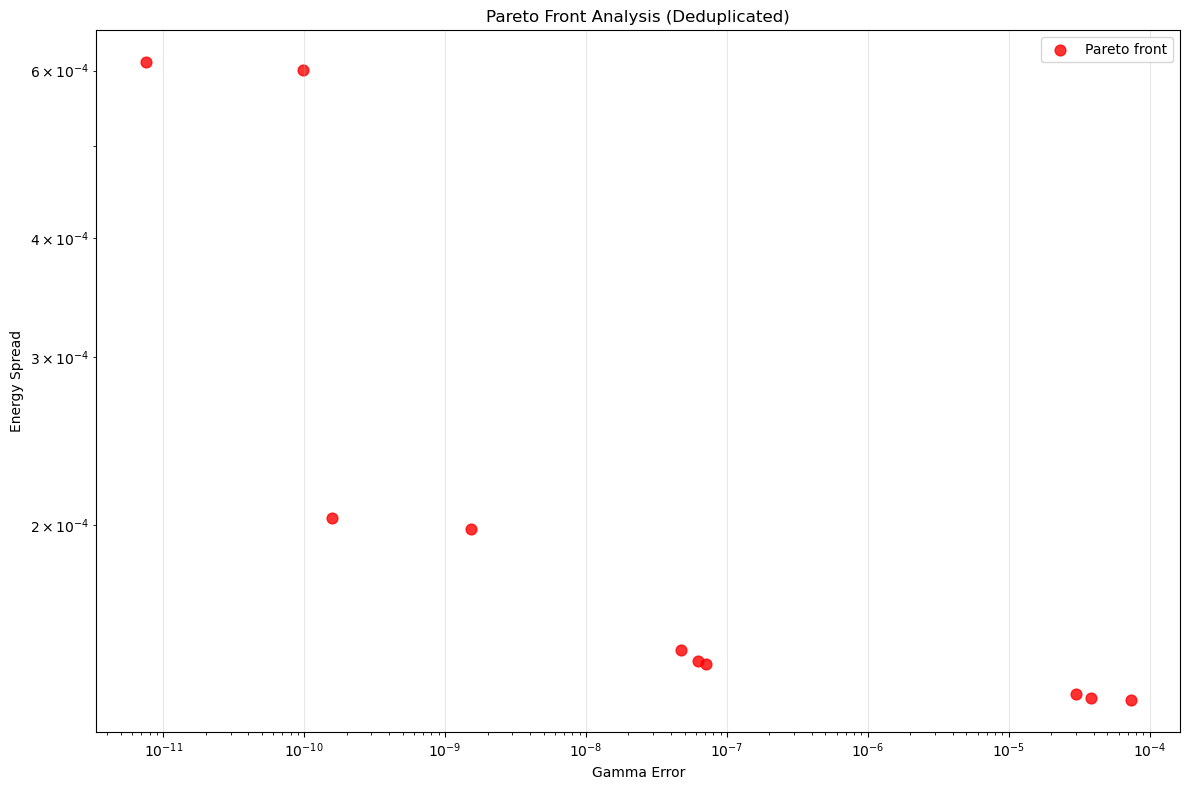

In [11]:
# 7. Plot Pareto front with best solutions highlighted
fig, ax = plt.subplots(figsize=(12, 8))

# All unique solutions
#ax.scatter(pop_df_unique['gamma_error'], pop_df_unique['energy_spread'], 
#          alpha=0.3, s=30, c='lightblue', label='All unique solutions')

# Pareto front
ax.scatter(pareto_df['gamma_error'], pareto_df['energy_spread'], 
          alpha=0.8, s=60, c='red', label='Pareto front')

ax.set_xlabel('Gamma Error')
ax.set_ylabel('Energy Spread')
ax.set_title('Pareto Front Analysis (Deduplicated)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

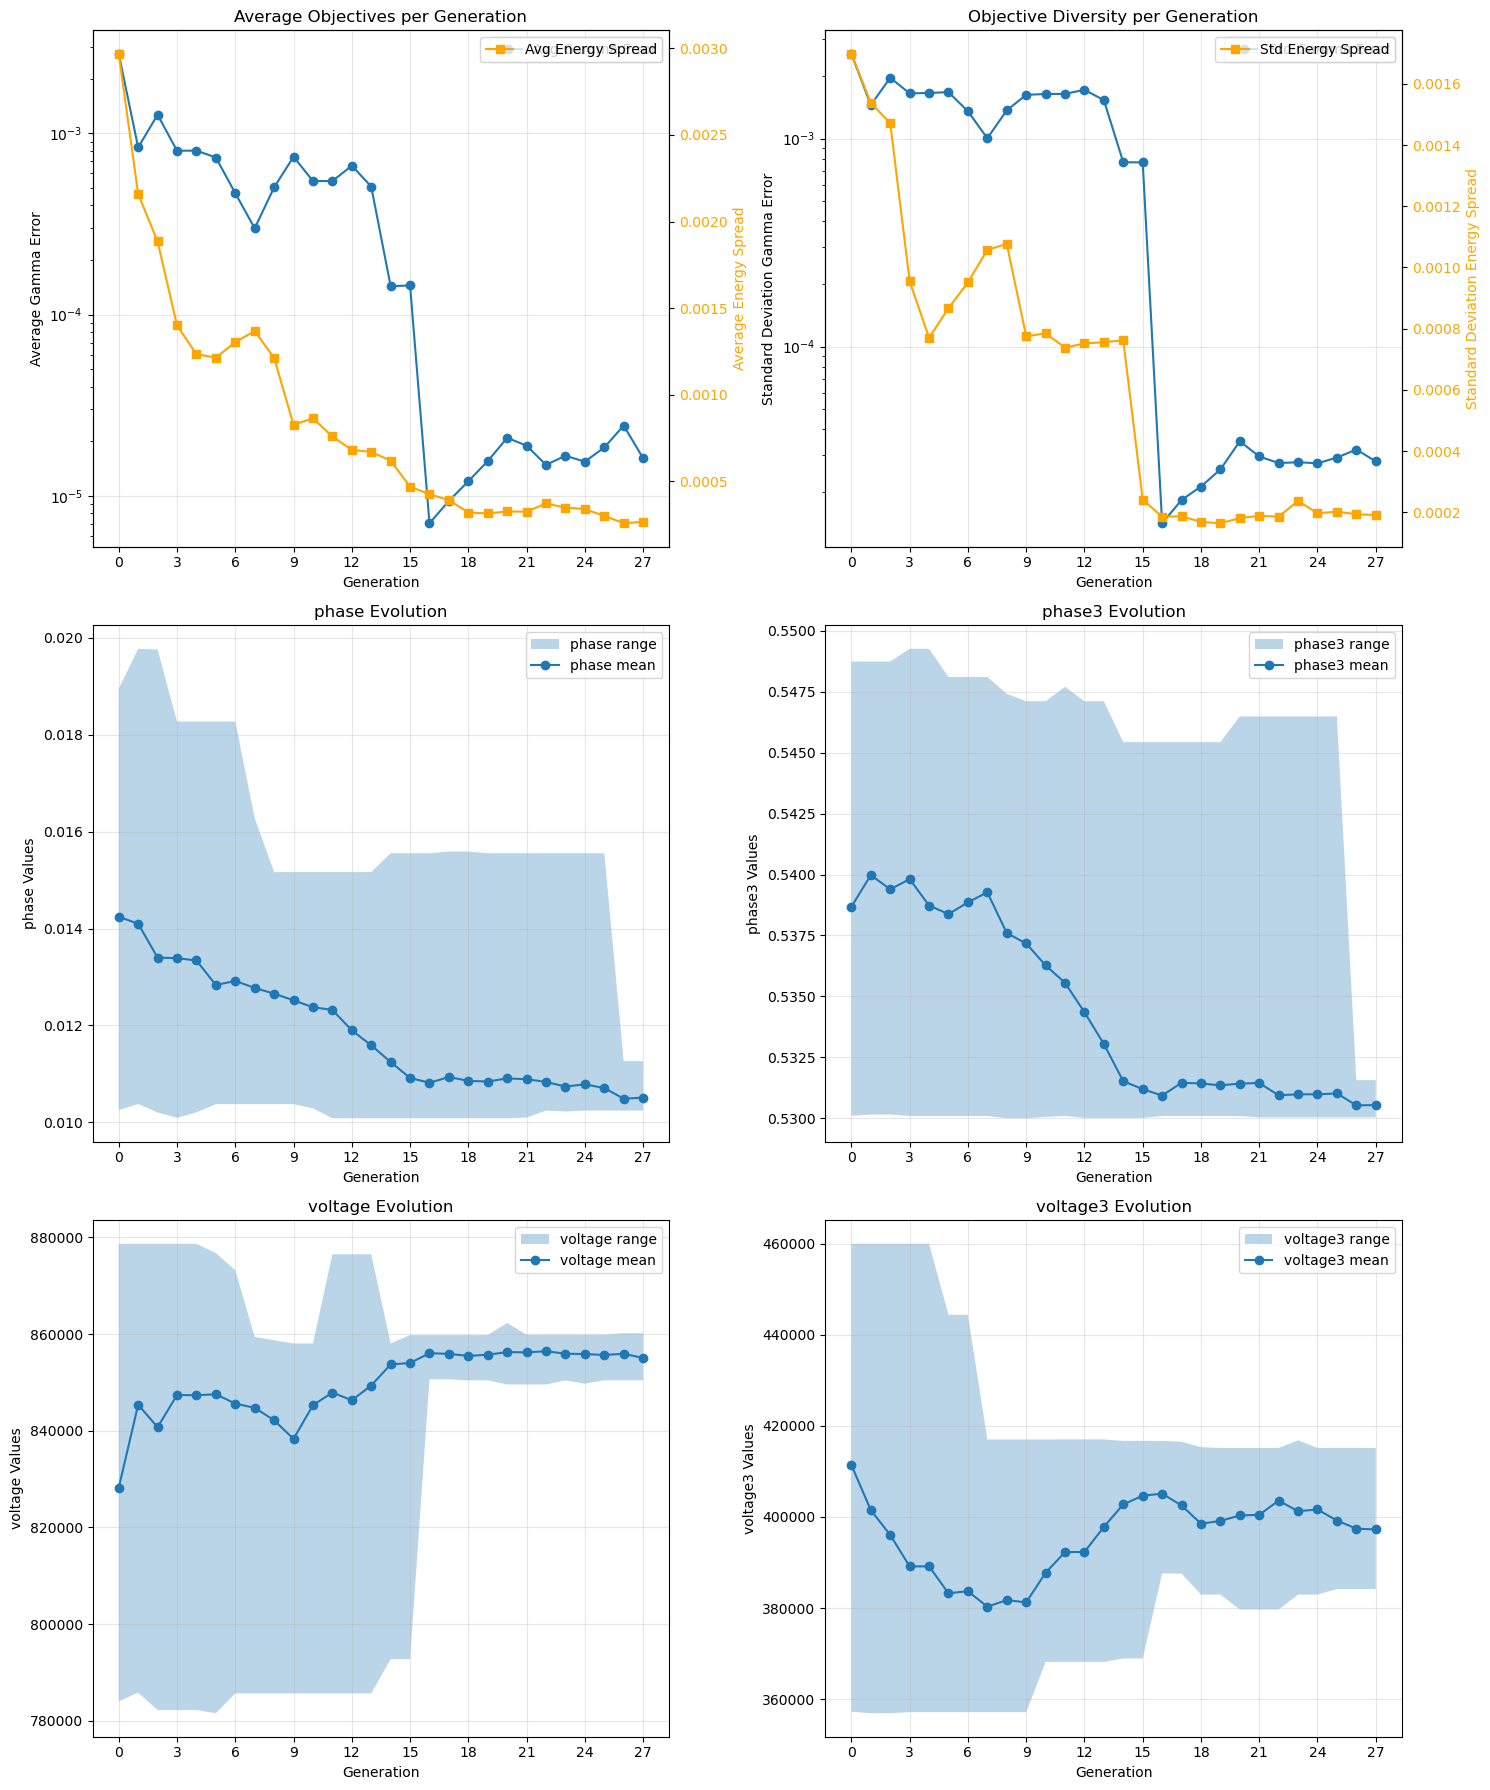

In [12]:
# 8. Generation-wise analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Average objectives per generation
avg_obj = pop_df.groupby('generation')[objectives].mean()
axes[0,0].plot(avg_obj.index, avg_obj['gamma_error'], 'o-', label='Avg Gamma Error')
axes[0,0].set_xlabel('Generation')
axes[0,0].set_ylabel('Average Gamma Error')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Average Objectives per Generation')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()
axes[0,0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax2 = axes[0,0].twinx()
ax2.plot(avg_obj.index, avg_obj['energy_spread'], 's-', color='orange', label='Avg Energy Spread')
ax2.set_ylabel('Average Energy Spread', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Standard deviation of objectives per generation
std_obj = pop_df.groupby('generation')[objectives].std()
axes[0,1].plot(std_obj.index, std_obj['gamma_error'], 'o-', label='Std Gamma Error')
axes[0,1].set_xlabel('Generation')
axes[0,1].set_ylabel('Standard Deviation Gamma Error')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Objective Diversity per Generation')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()
axes[0,1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax3 = axes[0,1].twinx()
ax3.plot(std_obj.index, std_obj['energy_spread'], 's-', color='orange', label='Std Energy Spread')
ax3.set_ylabel('Standard Deviation Energy Spread', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')
ax3.legend(loc='upper right')

# Individual variable evolution - each variable gets its own plot
var_positions = [axes[1,0], axes[1,1], axes[2,0], axes[2,1]]

for i, var in enumerate(variables):
    var_stats = pop_df.groupby('generation')[var].agg(['min', 'max', 'mean'])
    ax = var_positions[i]
    
    ax.fill_between(var_stats.index, var_stats['min'], var_stats['max'], 
                   alpha=0.3, label=f'{var} range')
    ax.plot(var_stats.index, var_stats['mean'], 'o-', label=f'{var} mean')
    ax.set_xlabel('Generation')
    ax.set_ylabel(f'{var} Values')
    ax.set_title(f'{var} Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [13]:
# 9. Select solutions from Pareto front and read particle data
print("=== PARETO FRONT SOLUTIONS ===")
print(f"Number of Pareto optimal solutions: {len(pareto_df)}")

# Display Pareto front solutions with their IDs
print("\nPareto front solutions:")

# Best solutions
best_gamma = pareto_df.sort_values(by=['gamma_error', 'energy_spread'])
best_energy = pareto_df.sort_values(by=['energy_spread', 'gamma_error'])

pareto_display = best_energy[['ID', 'mean_gamma'] + objectives]
#pareto_display_energy = best_energy[['ID', 'mean_gamma'] + objectives]
pd.set_option('display.expand_frame_repr', False)
print(pareto_display)
#print(pareto_display_energy.head())


=== PARETO FRONT SOLUTIONS ===
Number of Pareto optimal solutions: 10

Pareto front solutions:
                                   ID  mean_gamma   gamma_error  energy_spread
582  c49d2f3dbf2d4298f8b89f695f5e61e1   25.617450  7.329107e-05       0.000131
844  ba008957c5b11846a35e285b6bcbd1d9   25.556746  3.808265e-05       0.000132
879  c8b73b2b12d3d3ef2e4a86908de772f0   25.538979  2.993840e-05       0.000133
713  03e4ba5a537b5dc326ec7e2eb3dbeb07   25.406756  7.075561e-08       0.000143
878  7a73a23cd8441f68d305798312ceee91   25.393668  6.215272e-08       0.000144
843  fdc6832c9f039ab2e8df4f0c55d9369d   25.405513  4.711486e-08       0.000148
807  2c24aa59549f0375a30d42ca37a33640   25.399010  1.520483e-09       0.000198
808  788f1a8130940332dfa8e3eb8bac5cd9   25.399681  1.576716e-10       0.000204
809  3a0aa832178a81fe4113b140f2394c0c   25.399748  9.809070e-11       0.000601
388  6736eadeaaabacea0f97a2f9b756744f   25.399930  7.501143e-12       0.000612


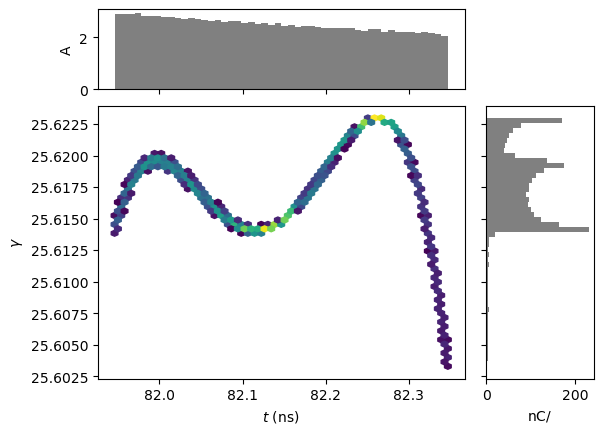

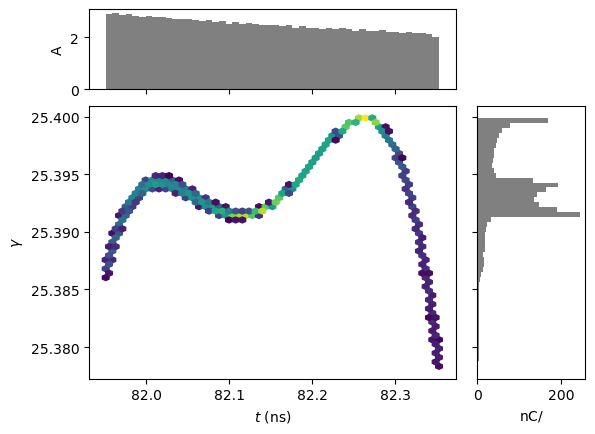

In [14]:
selected_ID = ["c49d2f3dbf2d4298f8b89f695f5e61e1", "7a73a23cd8441f68d305798312ceee91"]
pgs = []
#global_y_limits = (25, 25.6)
for i, ID in enumerate(selected_ID):    
    # Read particle data
    pg = ParticleGroup(OUTPUT_PATH + ID + ".h5")
    pgs.append(pg)
    pg.plot('t', 'gamma')

In [15]:
best_energy[['ID', 'energy_spread'] + variables]

,ID,energy_spread,phase,phase3,voltage,voltage3
582,c49d2f3dbf2d4298f8b89f695f5e61e1,0.000131,0.010245,0.530122,859801.666261,394684.909696
844,ba008957c5b11846a35e285b6bcbd1d9,0.000132,0.010253,0.530055,857804.720169,394485.010055
879,c8b73b2b12d3d3ef2e4a86908de772f0,0.000133,0.010260,0.530184,857146.266547,394151.257738
713,03e4ba5a537b5dc326ec7e2eb3dbeb07,0.000143,0.010243,0.530303,851620.047706,388757.031162
878,7a73a23cd8441f68d305798312ceee91,0.000144,0.010243,0.530303,851192.402949,388757.031162
843,fdc6832c9f039ab2e8df4f0c55d9369d,0.000148,0.010507,0.530999,851622.624178,388853.944806
807,2c24aa59549f0375a30d42ca37a33640,0.000198,0.010510,0.531438,850427.864968,384746.829353
808,788f1a8130940332dfa8e3eb8bac5cd9,0.000204,0.010561,0.531438,850427.864968,384574.228583
809,3a0aa832178a81fe4113b140f2394c0c,0.000601,0.010941,0.531046,857513.830018,415133.955153
388,6736eadeaaabacea0f97a2f9b756744f,0.000612,0.010941,0.531118,857513.830018,415151.891872


In [16]:
best_id = "b9ff479a2d04c7b27e821ad6bf8ec6f2"
row = pop_df[pop_df['ID'] == best_id]
if not row.empty:
    print(row[['phase', 'phase3', 'voltage', 'voltage3']])
else:
    print("ID not found!")

ID not found!


In [17]:
pgs[idx]['mean_energy']

IndexError: list index out of range